In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Assuming the CSV file containing the data is named "data.csv"
buyername = "buyerIQ162270"
data = pd.read_csv('data/final_data/' + buyername + '.csv')
data.index = pd.to_datetime(data['QuarterYear'])
data = data.drop(columns=['node','QuarterYear'], axis=1)
data.head()

C:\Users\anagh\AppData\Local\Temp\ipykernel_20000\2436532329.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = pd.to_datetime(data['QuarterYear'])


,outdegree,katz,clustering,dir_clustering,w_clustering,weight_dir_clustering,undirected_betweenness,undirected_Weighted_betweenness,Number of Deals,Total Deal Value
QuarterYear,,,,,,,,,,
2003-01-01,0.002752,0.028476,0.0,0.0,0.0,0.0,0.000008,0.000008,0.0,0.00
2003-04-01,0.002577,0.027538,0.0,0.0,0.0,0.0,0.000007,0.000007,0.0,0.00
2003-07-01,0.002427,0.026700,0.0,0.0,0.0,0.0,0.000007,0.000007,0.0,0.00
2003-10-01,0.003019,0.025767,0.0,0.0,0.0,0.0,0.000010,0.000010,1.0,1078.28
2004-01-01,0.002863,0.025063,0.0,0.0,0.0,0.0,0.000009,0.000009,0.0,0.00


In [3]:

# Separate features and target
X = data.iloc[:, :-2]  # Features (network metrics)
y1 = data.iloc[:, -1]   # Target (value of deals)
y2 = data.iloc[:, -2]   # Targert(number of deals)

# Convert target to binary values (0 or 1)
y_binary = np.where(y2 > 0, 1, 0)

# Scale the features to a range between 0 and 1
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
# Assuming you have data from Q1 2010 to Q4 2022
train_size = int(len(X_scaled) * 0.8)  # Use 80% of the data for training
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_binary[:train_size], y_binary[train_size:]


In [5]:
# Define the window size (number of previous quarters to consider)
window_size = 4

# Function to create sequences
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for training and testing data
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window_size, X_train_seq.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [7]:
# Assuming you have 50 epochs and a batch size of 32
epochs = 100
batch_size = 20

history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=batch_size, validation_split=0.1)


Epoch 1/100
3/3 [==============================] - 9s 1s/step - loss: 0.6923 - accuracy: 0.5600 - val_loss: 0.6748 - val_accuracy: 0.8333
Epoch 2/100
3/3 [==============================] - 0s 70ms/step - loss: 0.6897 - accuracy: 0.5800 - val_loss: 0.6621 - val_accuracy: 0.8333
Epoch 3/100
3/3 [==============================] - 0s 45ms/step - loss: 0.6861 - accuracy: 0.5800 - val_loss: 0.6519 - val_accuracy: 0.8333
Epoch 4/100
3/3 [==============================] - 0s 45ms/step - loss: 0.6854 - accuracy: 0.5800 - val_loss: 0.6398 - val_accuracy: 0.8333
Epoch 5/100
3/3 [==============================] - 0s 55ms/step - loss: 0.6828 - accuracy: 0.5800 - val_loss: 0.6313 - val_accuracy: 0.8333
Epoch 6/100
3/3 [==============================] - 0s 57ms/step - loss: 0.6812 - accuracy: 0.5800 - val_loss: 0.6239 - val_accuracy: 0.8333
Epoch 7/100
3/3 [==============================] - 0s 57ms/step - loss: 0.6799 - accuracy: 0.5800 - val_loss: 0.6168 - val_accuracy: 0.8333
Epoch 8/100
3/3 [=====

In [8]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


1/1 [==============================] - 0s 74ms/step - loss: 0.6714 - accuracy: 0.5833
Test loss: 0.6714
Test accuracy: 0.5833


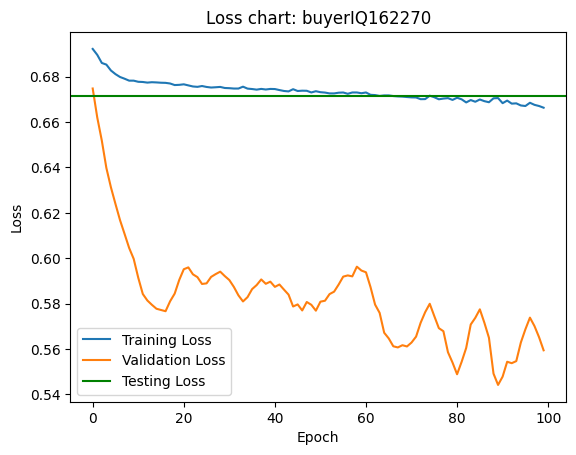

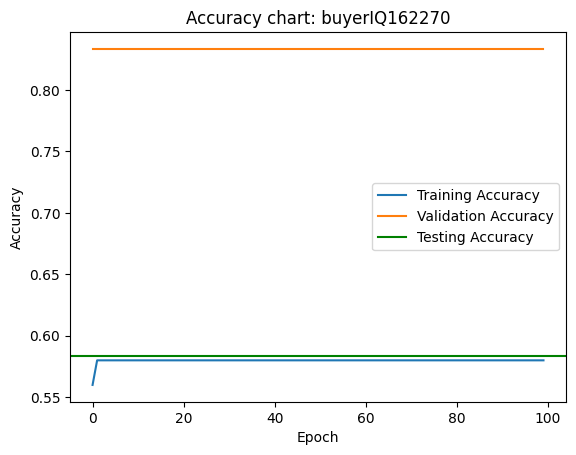

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=loss, color= 'g', label = 'Testing Loss')
plt.title("Loss chart: " + buyername)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('data/plots/loss_chart_' + buyername + '.png')
plt.show()


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=accuracy, color='g', label = 'Testing Accuracy')
plt.title("Accuracy chart: "+ buyername)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('data/plots/accuracy_chart_'+ buyername+  '.png')
plt.show()



In [10]:
y_pred_test = model.predict(X_test_seq)

1/1 [==============================] - 1s 1s/step


In [11]:
y_pred_labels = np.argmax(y_pred_test, axis=-1)

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Now, calculate the confusion matrix
cm = confusion_matrix(y_test_seq, y_pred_labels)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[7 0]
 [5 0]]


In [13]:
print(y_test_seq)
print(y_pred_labels)

[1 1 1 0 0 0 0 0 0 0 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0]


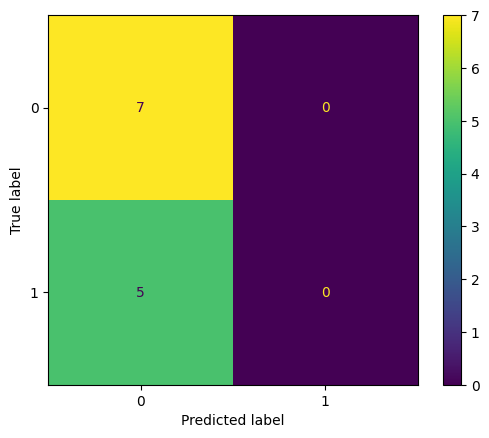

In [14]:
ConfusionMatrixDisplay(cm).plot()
plt.savefig('data/plots/cm_' + buyername + '.png')